In [1]:
%load_ext rpy2.ipython

/home/dan/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/dan/.local/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:


%%R
# install.packages(c('gdata','ggplot2','reshape','survival','rms','tidyverse','schoRsch','DescTools'))
# install.packages("BiocManager")
# library(BiocManager)
# BiocManager::install('made4')
# BiocManager::install('metafor')
require(gdata)
library(made4)
require(ggplot2)
library(reshape)
library(survival)
library(rms)
library(tidyverse)
library(schoRsch)
library(DescTools)

R[write to console]: Loading required package: gdata

R[write to console]: gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

R[write to console]: 

R[write to console]: gdata: Unable to load perl libaries needed by read.xls()
gdata: to support 'XLSX' (Excel 2007+) files.

R[write to console]: 

R[write to console]: gdata: Run the function 'installXLSXsupport()'
gdata: to automatically download and install the perl
gdata: libaries needed to support Excel XLS and XLSX formats.

R[write to console]: 
Attaching package: ‘gdata’


R[write to console]: The following object is masked from ‘package:stats’:

    nobs


R[write to console]: The following object is masked from ‘package:utils’:

    object.size


R[write to console]: The following object is masked from ‘package:base’:

    startsWith


R[write to console]: Loading required package: ade4

R[write to console]: Loading required package: RColorBrewer

R[write to console]: Loading required package: gplots

R[write to co

In [3]:


%%html
First each column is binned. Not yet ported to python.

In [4]:


%%R
dat <- NULL
# dat <- read.table("Made up immune data.txt", sep="\t", header=T, fill = T,dec = ",")
dat <- read.csv("./made-up-data.csv")
head(dat)
dat$status <-(dat$Event_last_followup)
dat$SurvObj <- with(dat, Surv(Time_Diagnosis_Last_followup, status == "Dead"))
# select tumor type, to analyse
dat2 <- dat[ which(
    dat$cohort == 'Colon' &
    dat$PreOp_treatment_yesno == 'No'), ]
# dichotomise variables based on median
for(i in names(dat2[,c( 8:33)] )){
  x  <-  as.data.frame(dat2[!is.na(dat2[i]),])
  x[i] <- ntiles(x, dv = i, bins=2)
  f <- "PatID"
  dat2 <- merge( dat2,  x[,c(f,i)], by = f, all = T)
  }

In [5]:



%%R
data<- dat2
# selecting variables for survival analysis - in this case variables are ALL immune cell data, dichotomised high vs low
covariates <- colnames(data[,c(36:61)])
# compution variables for survival
univ_formulas <- sapply(covariates,
                        function(x) as.formula(paste('SurvObj~', x)))
univ_models <- lapply( univ_formulas, function(x){coxph(x, data = data)})
# Extract data
univ_results <- lapply(univ_models,
                       function(x){
                         x <- summary(x)
                         p.value<-signif(x$wald["pvalue"], digits=3)
                         wald.test<-signif(x$wald["test"], digits=2)
                         beta<-signif(x$coef[1], digits=2);#coeficient beta
                         HR <-signif(x$coef[2], digits=2);#exp(beta)
                         HR.confint.lower <- signif(x$conf.int[,"lower .95"], 2)
                         HR.confint.upper <- signif(x$conf.int[,"upper .95"],2)
                         HR <- paste0(HR, " (",
                                      HR.confint.lower, "-", HR.confint.upper, ")")


                         coef<-signif(x$coef[1], digits=3);#coeficient beta
                         se.coef<-signif(x$coef[3], digits=3);#coeficient se(coef)

                         res<-c(beta, HR, wald.test, p.value, coef, se.coef)
                         names(res)<-c("beta", "HR (95% CI for HR)", "wald.test",
                                       "p.value", "coef", "se.coef")

                         return(res)
                         #return(exp(cbind(coef(x),confint(x))))
                       })
Cox <- t(as.data.frame(univ_results, check.names = F))
Cox <- data.frame(Cox)

In [6]:


Cox_R = %Rget Cox
Cox_R

,beta,HR..95..CI.for.HR.,wald.test,p.value,coef,se.coef
CD4_TUMOR.y,-0.4,0.67 (0.45-1),3.8,0.0524,-0.4,0.206
CD4_Treg_TUMOR.y,-0.14,0.87 (0.57-1.3),0.41,0.522,-0.137,0.213
CD8_TUMOR.y,-0.25,0.78 (0.52-1.2),1.6,0.212,-0.252,0.202
CD8_Treg_TUMOR.y,-0.13,0.88 (0.57-1.3),0.38,0.539,-0.132,0.215
B_cells_TUMOR.y,0.065,1.1 (0.71-1.6),0.1,0.751,0.065,0.205
CD4_STROMA.y,-0.39,0.68 (0.44-1),3.2,0.0755,-0.387,0.218
CD4_Treg_STROMA.y,-0.47,0.62 (0.39-0.99),4,0.0441,-0.473,0.235
CD8_STROMA.y,-0.27,0.76 (0.5-1.2),1.6,0.211,-0.27,0.215
CD8_Treg_STROMA.y,-0.089,0.92 (0.59-1.4),0.16,0.688,-0.0887,0.221
B_cells_STROMA.y,-0.1,0.9 (0.59-1.4),0.23,0.628,-0.105,0.216


In [7]:


# !pip install --user lifelines
from lifelines import CoxPHFitter
import pandas as pd

In [8]:


%%R
# write to csv because cannot convert the Surv object from dat2
write.csv(dat2, './dichotomized.csv')

In [9]:


dd = pd.read_csv('./dichotomized.csv')
dd['T'] = dd['Time_Diagnosis_Last_followup']
dd['E'] = dd['status'] == 'Dead'
covariates = [ c for c in dd.columns if c.endswith('.y') ]
TE = ['T', 'E']

In [10]:


univ_results = {}
for c in covariates:
    dd_c = dd[ [c] + TE ]
    dd_c = dd_c[~pd.isnull(dd_c).any(axis=1)]
    # dd_c = dd_c[~pd.isnull(dd).any(axis=1)]
    # My main questions to them:
    # - Why is there NA in their data?
    # - Why not remove all rows with NA instead of those that are NA for the current column?
    cph = CoxPHFitter()
    cph.fit(dd_c, 'T', event_col='E')
    univ_results[c] = cph

In [11]:


Cox_py = pd.concat([v.summary for v in univ_results.values()])
Cox_py

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
CD4_TUMOR.y,-0.400017,0.670308,0.206231,-0.804222,0.004187,0.447436,1.004196,-1.939661,0.052421,4.253713
CD4_Treg_TUMOR.y,-0.136522,0.872387,0.213329,-0.554639,0.281595,0.574280,1.325241,-0.639961,0.522198,0.937332
CD8_TUMOR.y,-0.252271,0.777034,0.202057,-0.648296,0.143753,0.522936,1.154599,-1.248515,0.211843,2.238935
CD8_Treg_TUMOR.y,-0.132277,0.876098,0.215228,-0.554116,0.289562,0.574580,1.335842,-0.614590,0.538825,0.892111
B_cells_TUMOR.y,0.064981,1.067138,0.204860,-0.336538,0.466499,0.714239,1.594403,0.317195,0.751096,0.412931
CD4_STROMA.y,-0.387336,0.678863,0.217905,-0.814422,0.039750,0.442895,1.040551,-1.777544,0.075479,3.727784
CD4_Treg_STROMA.y,-0.472840,0.623230,0.234879,-0.933194,-0.012486,0.393295,0.987591,-2.013125,0.044102,4.503027
CD8_STROMA.y,-0.269785,0.763544,0.215489,-0.692135,0.152566,0.500506,1.164819,-1.251966,0.210582,2.247543
CD8_Treg_STROMA.y,-0.088653,0.915163,0.221003,-0.521811,0.344506,0.593445,1.411293,-0.401137,0.688319,0.538850
B_cells_STROMA.y,-0.104844,0.900465,0.216280,-0.528746,0.319058,0.589344,1.375831,-0.484758,0.627848,0.671513


In [12]:


%%html
Results between R and python versions match up. The row names are slightly different but here they are side by side.

In [13]:


Cox_both = pd.concat([Cox_py, Cox_R], axis=1)
Cox_both[['coef', 'beta', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'HR..95..CI.for.HR.', 'p', 'p.value']]

,coef,coef,beta,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,HR..95..CI.for.HR.,p,p.value
CD4_TUMOR.y,-0.400017,-0.4,-0.4,0.670308,0.447436,1.004196,0.67 (0.45-1),0.052421,0.0524
CD4_Treg_TUMOR.y,-0.136522,-0.137,-0.14,0.872387,0.574280,1.325241,0.87 (0.57-1.3),0.522198,0.522
CD8_TUMOR.y,-0.252271,-0.252,-0.25,0.777034,0.522936,1.154599,0.78 (0.52-1.2),0.211843,0.212
CD8_Treg_TUMOR.y,-0.132277,-0.132,-0.13,0.876098,0.574580,1.335842,0.88 (0.57-1.3),0.538825,0.539
B_cells_TUMOR.y,0.064981,0.065,0.065,1.067138,0.714239,1.594403,1.1 (0.71-1.6),0.751096,0.751
CD4_STROMA.y,-0.387336,-0.387,-0.39,0.678863,0.442895,1.040551,0.68 (0.44-1),0.075479,0.0755
CD4_Treg_STROMA.y,-0.472840,-0.473,-0.47,0.623230,0.393295,0.987591,0.62 (0.39-0.99),0.044102,0.0441
CD8_STROMA.y,-0.269785,-0.27,-0.27,0.763544,0.500506,1.164819,0.76 (0.5-1.2),0.210582,0.211
CD8_Treg_STROMA.y,-0.088653,-0.0887,-0.089,0.915163,0.593445,1.411293,0.92 (0.59-1.4),0.688319,0.688
B_cells_STROMA.y,-0.104844,-0.105,-0.1,0.900465,0.589344,1.375831,0.9 (0.59-1.4),0.627848,0.628


In [14]:


%%html
The rest of their R code is a meta-analysis. I think this is done to get the summary estimate written at the end of the forest plot.
I think this also sets weight sizes of the squares in the forest plot.

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: The following object is masked from ‘package:reshape’:

    expand


R[write to console]: Loading 'metafor' package (version 2.1-0). For an overview 
and introduction to the package please type: help(metafor).

R[write to console]: 
Attaching package: ‘metafor’


R[write to console]: The following object is masked from ‘package:rms’:

    vif




 num [1:26] 0.0524 0.522 0.212 0.539 0.751 0.0755 0.0441 0.211 0.688 0.628 ...


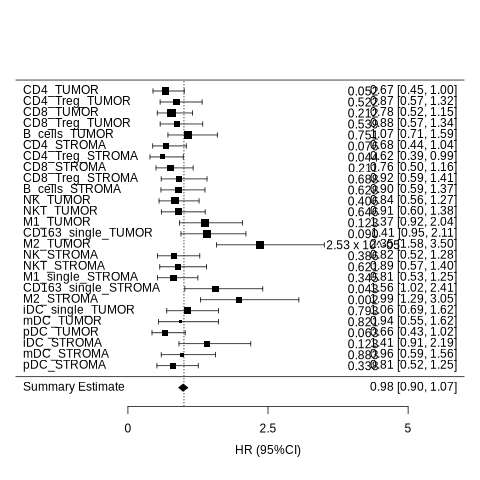

In [15]:


%%R
library(metafor)
###########################
#### remove 'y' from names
names <- row.names(Cox)
foo = function(x){
  return(gsub(".y","",x))
}
names <-foo(names)
colnames(Cox)
labs <- names
yi   <- as.numeric(as.character(Cox$coef))
sei  <- as.numeric(as.character(Cox$se.coef))
p.vals  <- as.numeric(as.character(Cox$p.value))
str(p.vals)
p.vals  <- as.numeric(p.vals)
# Combine data into summary estimate
res  <- rma(yi=yi, sei=sei, method="FE")
summary(res)
#
# Format pvalues so only those bellow 0.01 are scientifically notated
p.vals <- ifelse(p.vals < 0.001,
                 format(p.vals,digits = 3,scientific = TRUE,trim = TRUE),
                 format(round(p.vals, 3), nsmall=2, trim=TRUE))
p.vals <- gsub('e(.*)', ' x 10^\\1', p.vals)
# Plot combined data
# options(repr.plot.width=8, repr.plot.height=7)
forest(res, transf=exp, refline=1, xlab="HR (95%CI)",
       slab=labs, ilab = p.vals, ilab.xpos = 4.2, mlab="Summary Estimate", alim=c(0,5), xlim=c(-2,6),steps=3, cex=1)

In [16]:


%%html
Trying a multivariate model. This is not in their R code and Artur said not what they want to do. Included here for completeness.

In [17]:


dd_all = dd[ covariates + TE ]
dd_all = dd_all[~pd.isnull(dd_all).any(axis=1)]
cph = CoxPHFitter()
cph.fit(dd_all, 'T', event_col='E')
cph.print_summary()